In [1]:
from importlib import reload

import pandas as pd
from scipy.sparse import csr_matrix
import numpy as np

from sklearn.preprocessing import normalize

import matplotlib
import matplotlib.pyplot as plt


import trails.hyptrails as ht
import trails.mtmc.ml.deterministic.default as det
import trails.mtmc.ml.direct.optimized as directo

import trails.mtmc.common as common 

import itertools


In [2]:
# loading flickr data

data_raw = pd.read_csv("data/flickr/flickr-mixedtrails.csv")
# data_raw

# Data Exploration

In [3]:
# print columns

# for t in data_raw.columns:
#     if "tag" not in t:
#         print(t)

In [4]:
# some statistics about tourists and locals, etc.

data = data_raw
print("Number of transitions:", len(data))
print("Number of tourists:", len(data[data["owner_isTourist"] == "T"]))
print("Number of local:", len(data[data["owner_isTourist"] != "T"]))
print("Number of tourists (time):", len(data[data["path_duration"] <= 21 * 24 * 60 * 60 * 1000]))
print("Number of locals (time):", len(data[data["path_duration"] > 21 * 24 * 60 * 60 * 1000]))

data_raw["path_duration_days"] = data_raw["path_duration"] / 1000 / 60 / 60 / 24
data_raw_selected = data_raw[data_raw["path_duration_days"] < 5000]
data_raw_selected[["path_owner", "path_duration_days"]].groupby("path_owner").agg("max").describe()

Number of transitions: 386981
Number of tourists: 76667
Number of local: 310314
Number of tourists (time): 76667
Number of locals (time): 310314


,path_duration_days
count,26196.000000
mean,339.997422
std,570.797282
min,0.000000
25%,2.046765
50%,26.199369
75%,496.921887
max,4973.369745


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f121b2a43c8>]], dtype=object)

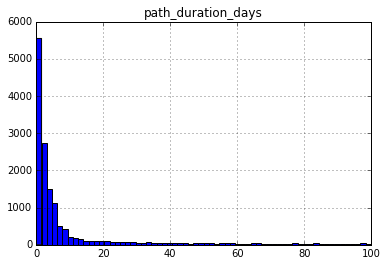

In [5]:
# path durations histogram

%matplotlib inline
data_raw_selected = data_raw[data_raw["path_duration_days"] < 100]
data_raw_selected[["path_owner", "path_duration_days"]].groupby("path_owner").agg("max").hist(bins=64)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f121b55a390>]], dtype=object)

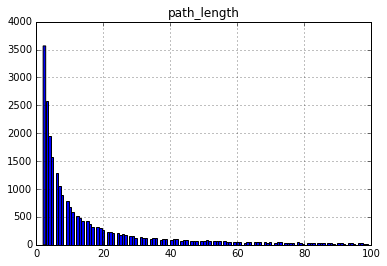

In [6]:
# path length histogram

%matplotlib inline
data_raw_selected = data_raw[data_raw["path_length"] < 100]
data_raw_selected[["path_owner", "path_length"]].groupby("path_owner").agg("max").hist(bins=128)

# Data Preparation

In [7]:
# add hour of the day attribute

import datetime
def convert_time(timestamp_milli, offset=-6):
    d = datetime.datetime.fromtimestamp(timestamp_milli / 1000)
    return np.abs(((d.hour + offset) % 24) - 12 + d.minute/60)**2 / 12**2

# test
# convert_time(datetime.datetime(2016, 11, 8, 12, 0, 0).timestamp() * 1000, offset=0)

data["hour_of_day"] = data["dst_photoDateTaken"].apply(convert_time)

In [8]:
filtered = data_raw

# filter self-transitions
filtered = filtered[filtered["src_tractIndex"] != filtered["dst_tractIndex"]]

In [9]:
filtered[filtered["src_tractIndex"] != filtered["dst_tractIndex"]].shape

(386981, 226)

In [10]:
data = filtered
print("Number of transitions:", len(data))
print("Number of tourists:", len(data[data["owner_isTourist"] == "T"]))
print("Number of local:", len(data[data["owner_isTourist"] != "T"]))
print("Number of tourists (time):", len(data[data["path_duration"] > 1000 * 60 * 60 * 24 * 21]))
print("Number of local (time):", len(data[data["path_duration"] <= 1000 * 60 * 60 * 24 * 21]))

Number of transitions: 386981
Number of tourists: 76667
Number of local: 310314
Number of tourists (time): 310314
Number of local (time): 76667


In [11]:
# extract transitions
tmp =  filtered
# tmp = tmp[tmp["owner_isTourist"] == "T"]
#tmp = tmp[tmp["path_duration"] <= 1000 * 60 * 60 * 24 * 21]
transitions = tmp[["src_tractIndex", "dst_tractIndex"]].values
print(transitions.shape)

(386981, 2)


In [12]:
# transitions counts
n_states = 288
transition_counts = csr_matrix(
    (np.ones(transitions.shape[0]), (transitions[:, 0], transitions[:, 1])), (n_states, n_states))

# Hypotheses

In [13]:
# load and normalize hypotheses

import glob
from collections import OrderedDict
path = "data/flickr/subtrails-prox-poi-hyp/hyp-*.txt"

hyps = OrderedDict()
for f in sorted(glob.glob(path)):
    print(f)
    name = "".join(f.split("/")[-1].split(".")[0:-1])
    hyps[name] = csr_matrix(np.loadtxt(f, delimiter=",")[:,1:])
    hyps[name] = csr_matrix(hyps[name] / hyps[name].sum(axis=1))  
hyps["uniform"] = csr_matrix(np.full([n_states, n_states], 1 / n_states))

data/flickr/subtrails-prox-poi-hyp/hyp-prox-0.4.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-0.7.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-1.5.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-2.5.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-5.0.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.4-0.4.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.4-0.7.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.4-1.5.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.4-2.5.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.4-5.0.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.7-0.4.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.7-0.7.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.7-1.5.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.7-2.5.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-0.7-5.0.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-1.5-0.4.txt
data/flickr/subtrails-prox-poi-hyp/hyp-prox-poi-1.5-0.7.txt
data/flickr/subtrail

# Experiments

In [23]:
# experiment parameters

ks = [0, 0.001,0.003, 0.01, 0.03, 0.1, 0.3,1,3,10,30,100,300,1000,3000,10000,30000,100000,300000,1000000,3000000,10000000,30000000,100000000,30000000,100000000,300000000,1000000000,3000000000,10000000000]
n_samples = 1 # already stable at 1 sample; tried up to 50 samples

In [15]:
def exp_homo(hyp, transition_counts=transition_counts): 
    return { "x": ks, "y": [ht.evidence_markov_matrix(
                n_states, 
                transition_counts,
                hyp * k,
                smoothing=1) 
            for k in ks] }

def exp_prob(p_gt, hyp, mix=True, transitions=transitions):
    
    if mix:
        hyp = common.calc_mixed_hypothesis(
            p_gt, 
            np.array([ hyp[0], hyp[1]]))
        
    return { "x": ks, "y": [directo.log_ml(
        transitions,
        p_gt, 
        np.array([hyp[0] * k, hyp[1] * k]), 
        smoothing=1, 
        n_samples=n_samples) for k in ks] }

## Homogeneous Experiments

In [30]:
# run homogeneous experiments
results = OrderedDict()
for key, value in hyps.items():
    results[key] =  exp_homo(hyps[key])

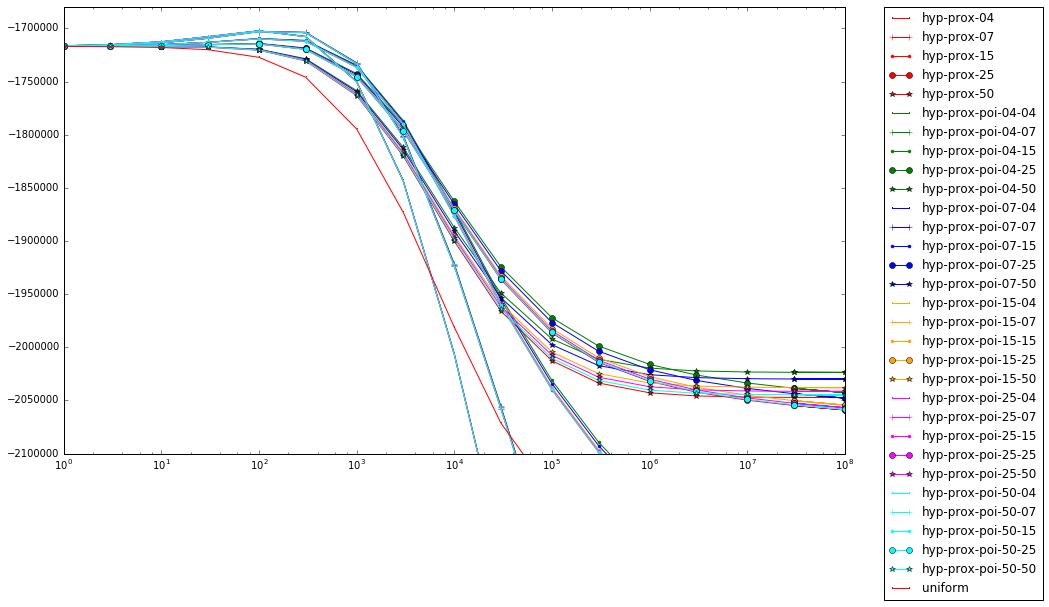

In [31]:
# plot all results
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (14,8)
color_iter = itertools.cycle(np.repeat(["red", "green", "blue", "orange", "magenta","cyan"], 5))
marker_iter = itertools.cycle([',', '+', '.', 'o', '*'])
start=7
stop=26
ax=plt.subplot(111)
for key, e in results.items():
#    if "prox-poi-50-25" in key or "prox-50" in key:
        plt.plot(e["x"][start:stop], e["y"][start:stop], label=key, color=next(color_iter), marker=next(marker_iter))
ax.legend()
ax.set_ylim([-2100000,-1680000])
ax.set_xscale("log", nonposx='clip')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

## Heterogeneous Experiments

In [33]:
# define sigmoid function to classify locals/toursits
import math
def sigmoid(x, offset=21, spread=1):
  return 1 / (1 + math.exp((-x + offset) / spread))
sigmoid = np.vectorize(sigmoid)

array(0.9999999992417439)

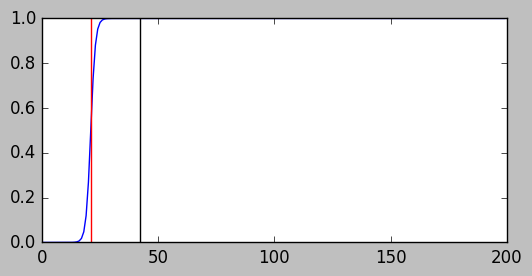

In [34]:
# explore sigmoid function
x = np.array(range(0,200))
plt.plot(x, sigmoid(x))
plt.axvline(x=21, color="red")
plt.axvline(x=42, color="black")
sigmoid(42)

In [35]:
# split by time
#p_gt_time = np.array([[g, 1-g] for g in data["hour_of_day"].values])

In [36]:
# group assignment probabilities: duration (probabilistic)
def p_gt_duration(data, offset=21, spread=1):
    return np.array(list(zip(
                sigmoid(data["path_duration_days"].values, offset, spread), 
                1 - sigmoid(data["path_duration_days"].values, offset, spread))))

In [37]:
# group assignment probabilities: duration (deterministic)
def static(data, offset=21):
    if data >= offset:
        return 0
    else:
        return 1
static = np.vectorize(static)

def p_gt_static(data, offset):
    return np.array(list(zip(
                static(data["path_duration_days"].values, offset), 
                1. - static(data["path_duration_days"].values, offset))))

### Comparison

In [38]:
p_gt = p_gt_duration(filtered, 21, 1)

In [39]:
results["hyp-prox-poi (04-25 / 04-25) @21/1"] = \
    exp_prob(p_gt, np.array([hyps["hyp-prox-poi-04-25"], hyps["hyp-prox-poi-04-25"]]))

In [40]:
results["hyp-prox-poi (04-50 / 04-50) @21/1"] = \
    exp_prob(p_gt, np.array([hyps["hyp-prox-poi-04-50"], hyps["hyp-prox-poi-04-50"]]))

In [41]:
results["hyp-prox-poi (04-25 / 04-50) @21/1"] = \
    exp_prob(p_gt, np.array([hyps["hyp-prox-poi-04-25"], hyps["hyp-prox-poi-04-50"]]))

In [42]:
results["hyp-prox-poi (04-50 / 04-25) @21/1"] = \
    exp_prob(p_gt, np.array([hyps["hyp-prox-poi-04-50"], hyps["hyp-prox-poi-04-25"]]))

In [43]:
p_gt = p_gt_static(filtered, 21)
results["hyp-prox-poi (04-50 / 04-25) @21"] = \
    exp_prob(p_gt, np.array([hyps["hyp-prox-poi-04-50"], hyps["hyp-prox-poi-04-25"]]))

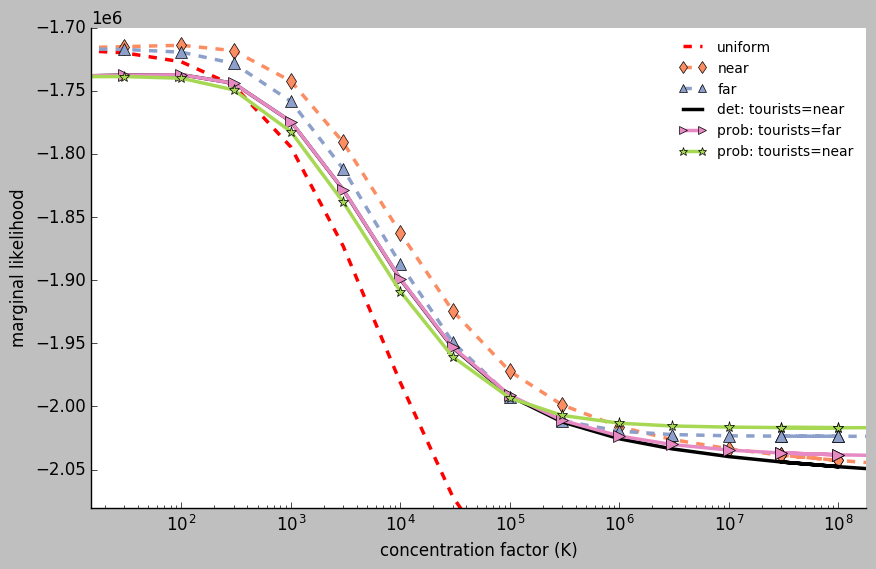

In [44]:
import matplotlib
import brewer2mpl

linestyles = ['-', '--', ':', "-."]
colors = brewer2mpl.get_map("Set2", "Qualitative", 5)
linewidth=2.5
style = {
    "hyp-prox-25": {
        "label": "prox 2.5km", 
        "marker": matplotlib.markers.MarkerStyle.filled_markers[0], 
        "color": colors.hex_colors[0],
        "linestyle": "--",
        "linewidth": linewidth
    },
    "hyp-prox-poi-04-25": {
        "label": "near", 
        "marker": "d", 
        "color": colors.hex_colors[1],
        "linestyle": "--",
        "linewidth": linewidth
    },
    "hyp-prox-poi-04-50": {
        "label": "far",
        "marker": matplotlib.markers.MarkerStyle.filled_markers[2], 
        "color": colors.hex_colors[2],
        "linestyle": "--",
        "linewidth": linewidth
    },
    "hyp-prox-poi (04-25 / 04-50) @21/1": {
        "label": "prob: tourists=far",
        "marker": matplotlib.markers.MarkerStyle.filled_markers[4], 
        "color": colors.hex_colors[3],
        "linestyle": "-",
        "linewidth": linewidth
    },
    "hyp-prox-poi (04-50 / 04-25) @21/1": {
        "label": "prob: tourists=near",
        "marker": "*", 
        "color": colors.hex_colors[4],
        "linestyle": "-",
        "linewidth": linewidth
    },
    "hyp-prox-poi (04-50 / 04-25) @21": {
        "label": "det: tourists=near",
        "marker": None, 
        "color": "black",
        "linestyle": "-",
        "linewidth": linewidth
    },
    "uniform": {
        "label": "uniform",
        "marker": None, 
        "color": "red",
        "linestyle": "--",
        "linewidth": linewidth
    },
    
}

keys = [
    "uniform",
    "hyp-prox-poi-04-25", 
    "hyp-prox-poi-04-50",
    "hyp-prox-poi (04-50 / 04-25) @21",
    "hyp-prox-poi (04-25 / 04-50) @21/1",
    "hyp-prox-poi (04-50 / 04-25) @21/1",
#     "hyp-prox-poi (04-50 / 04-50)",
#     "hyp-prox-poi (04-25 / 04-25)",
]

import trails.plot as pl 
fig, ax, leg = pl.plot(results, keys=keys, style=style, notebook=True, 
                       xlim=[15,180000000], ylim=[-2.08 * 10**6,-1.7*10**6],        
                       leg_loc="upper right",
                       leg_anchor=(1, 1))
fig, ax, leg = pl.plot(results, keys=keys, style=style, notebook=False, 
                       xlim=[15,180000000], ylim=[-2.08 * 10**6,-1.7*10**6], 
                       axis_labels=True, size=(6,2.8),
                       leg=False,
                       leg_loc="upper right",
                       leg_anchor=(1, 1),
                      leg_size=(1.8,2.8))
fig.savefig("out/flickr-links.eps", bbox_inches='tight')
leg.savefig("out/flickr-legend.eps", bbox_inches='tight')